## Setup

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
FORCE_CPU = False
SEED = 2384

HIDDEN_SIZE = 16
SIZE_PER_INPUT = 4
TASK_TRAIN_SIZE = 100000
TASK_TEST_SIZE = 1000
TASK_LR = 0.01
TASK_EPOCHS = 5000
TASK_SCHEDULER_PATIENCE = 1000

SAVE_MODEL = True
LOAD_MODEL = False
MODEL_PATH = "saved_models/hierarchical-equality.pt"

In [3]:
import random
from dataclasses import dataclass
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np

from scipy.ndimage import gaussian_filter1d

import pandas as pd

import matplotlib.pyplot as plt

import plotly.express as px

from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens.utils import to_numpy

from causal_networks.dag import DeterministicDAG
from causal_networks.variable_alignment import VariableAlignment

In [4]:
if not FORCE_CPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


## Training the model

In [5]:
@dataclass
class Config:
    input_size: int = 4
    hidden_size: int = 16
    output_size: int = 2

In [6]:
# Create a three layer hooked MLP
class MLP(HookedRootModule):
    def __init__(self, cfg: Config, device=None):
        super().__init__()

        if device is None:
            device = torch.device("cpu")

        self.device = device

        self.cfg = cfg

        self.hook_pre1 = HookPoint()
        self.layer1 = nn.Linear(cfg.input_size, cfg.hidden_size, bias=True, device=device)
        self.hook_mid1 = HookPoint()
        self.hook_pre2 = HookPoint()
        self.layer2 = nn.Linear(cfg.hidden_size, cfg.hidden_size, bias=True, device=device)
        self.hook_mid2 = HookPoint()
        self.hook_pre3 = HookPoint()
        self.layer3 = nn.Linear(cfg.hidden_size, cfg.output_size, bias=True, device=device)
        self.hook_mid3 = HookPoint()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.hook_pre1(x)
        x = self.hook_mid1(self.layer1(x))
        x = self.relu(x)
        x = self.hook_pre2(x)
        x = self.hook_mid2(self.layer2(x))
        x = self.relu(x)
        x = self.hook_pre3(x)
        x = self.hook_mid3(self.layer3(x))
        return x

In [7]:
# define the model
model = MLP(
    Config(hidden_size=HIDDEN_SIZE, input_size=4 * SIZE_PER_INPUT), device=device
)
model.setup()

print(model)

MLP(
  (hook_pre1): HookPoint()
  (layer1): Linear(in_features=16, out_features=16, bias=True)
  (hook_mid1): HookPoint()
  (hook_pre2): HookPoint()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (hook_mid2): HookPoint()
  (hook_pre3): HookPoint()
  (layer3): Linear(in_features=16, out_features=2, bias=True)
  (hook_mid3): HookPoint()
  (relu): ReLU()
)


In [8]:
def generate_grouped_data(n, size_per_input):
    """Generates n data points with 4 balanced groups,
       (w==x, y==z), (w==x, y!=z), (w!=x, y==z), (w!=x, y!=z)
       For the heirarchical equality task""" 
    
    data = np.empty((n, 4, size_per_input))
    labels = np.empty(n)

    quarter = n // 4

    # w==x, y!=z
    data[:quarter, 0] = data[:quarter, 1] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    data[:quarter, 2] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    data[:quarter, 3] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    labels[:quarter] = 0

    # w==x, y==z
    data[quarter:2*quarter, 0] = data[quarter:2*quarter, 1] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    data[quarter:2*quarter, 2] = data[quarter:2*quarter, 3] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    labels[quarter:2*quarter] = 1

    # w!=x, y==z
    data[2*quarter:3*quarter, 0] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    data[2*quarter:3*quarter, 1] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    data[2*quarter:3*quarter, 2] = data[2*quarter:3*quarter, 3] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    labels[2*quarter:3*quarter] = 0

    # w!=x, y!=z
    data[3*quarter:, 0] = np.random.uniform(-0.5, 0.5, (n - 3 * quarter, size_per_input))
    data[3*quarter:, 1] = np.random.uniform(-0.5, 0.5, (n - 3 * quarter, size_per_input))
    data[3*quarter:, 2] = np.random.uniform(-0.5, 0.5, (n - 3 * quarter, size_per_input))
    data[3*quarter:, 3] = np.random.uniform(-0.5, 0.5, (n - 3 * quarter, size_per_input))
    labels[3*quarter:] = 1

    data = data.reshape(n, 4 * size_per_input)

    permute = np.random.permutation(n)
    data = data[permute]
    labels = labels[permute]

    return data, labels

In [9]:
# generate the data
data, labels = generate_grouped_data(TASK_TRAIN_SIZE, SIZE_PER_INPUT)
val_data, val_labels = generate_grouped_data(TASK_TEST_SIZE, SIZE_PER_INPUT)

In [10]:
# train the network

# set the random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if LOAD_MODEL:

    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

else:

    # define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=TASK_LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=TASK_SCHEDULER_PATIENCE, verbose=True)

    # convert the data and labels to torch tensors
    data = torch.from_numpy(data).float()
    labels = torch.from_numpy(labels).long()

    data = data.to(device)
    labels = labels.to(device)
    model = model.to(device)

    # train the model
    for epoch in range(TASK_EPOCHS):
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        if (epoch+1) % 100 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, TASK_EPOCHS, loss.item()))

# test the model
val_data = torch.from_numpy(val_data).float()
val_labels = torch.from_numpy(val_labels).long()

with torch.no_grad():
    val_data = val_data.to(device)
    val_labels = val_labels.to(device)
    outputs = model(val_data)
    _, predicted = torch.max(outputs.data, 1)

    # compute the accuracy
    total = val_labels.size(0)
    correct = (predicted == val_labels).sum().item()
    print('Accuracy of the network on the test data: {} %'.format(100 * correct / total))

Epoch [100/5000], Loss: 0.0887
Epoch [200/5000], Loss: 0.0071
Epoch [300/5000], Loss: 0.0037
Epoch [400/5000], Loss: 0.0024
Epoch [500/5000], Loss: 0.0017
Epoch [600/5000], Loss: 0.0013
Epoch [700/5000], Loss: 0.0010
Epoch [800/5000], Loss: 0.0008
Epoch [900/5000], Loss: 0.0007
Epoch [1000/5000], Loss: 0.0006
Epoch [1100/5000], Loss: 0.0005
Epoch [1200/5000], Loss: 0.0004
Epoch [1300/5000], Loss: 0.0003
Epoch [1400/5000], Loss: 0.0003
Epoch [1500/5000], Loss: 0.0002
Epoch [1600/5000], Loss: 0.0002
Epoch [1700/5000], Loss: 0.0002
Epoch [1800/5000], Loss: 0.0002
Epoch [1900/5000], Loss: 0.0001
Epoch [2000/5000], Loss: 0.0001
Epoch [2100/5000], Loss: 0.0001
Epoch [2200/5000], Loss: 0.0001
Epoch [2300/5000], Loss: 0.0001
Epoch [2400/5000], Loss: 0.0001
Epoch [2500/5000], Loss: 0.0001
Epoch [2600/5000], Loss: 0.0001
Epoch [2700/5000], Loss: 0.0001
Epoch [2800/5000], Loss: 0.0000
Epoch [2900/5000], Loss: 0.0000
Epoch [3000/5000], Loss: 0.0000
Epoch [3100/5000], Loss: 0.0000
Epoch [3200/5000]

In [11]:
if SAVE_MODEL:
    torch.save(model.state_dict(), MODEL_PATH)

## Causal DAGS

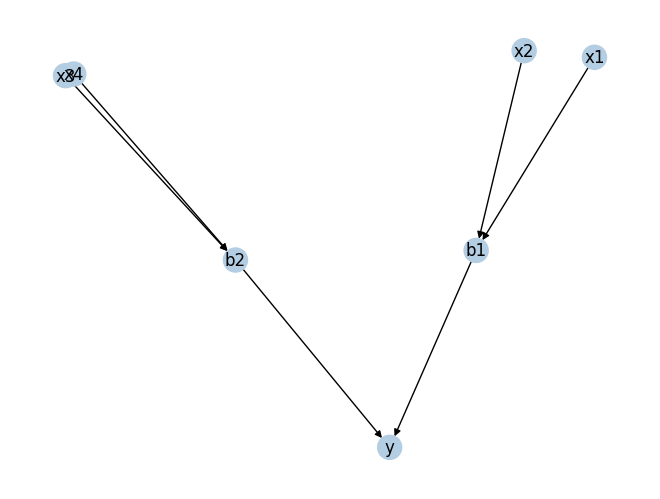

                           Node Information                            
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler ┃ Validator                   ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ -       │ array_float_validator(-, 4) │ -     │
│ x2   │ -            │ -       │ array_float_validator(-, 4) │ -     │
│ x3   │ -            │ -       │ array_float_validator(-, 4) │ -     │
│ x4   │ -            │ -       │ array_float_validator(-, 4) │ -     │
│ b1   │ compare_func │ -       │ bool_validator              │ -     │
│ b2   │ compare_func │ -       │ bool_validator              │ -     │
│ y    │ compare_func │ -       │ bool_validator              │ -     │
└──────┴──────────────┴─────────┴─────────────────────────────┴───────┘

In [12]:
def array_float_validator(value, size_per_input):
    return (
        isinstance(value, np.ndarray)
        and value.shape == (size_per_input,)
        and ((-0.5 <= value) & (value <= 0.5)).all()
    )


# Bit of a hack to make the table work
array_float_validator_size = partial(
    array_float_validator, size_per_input=SIZE_PER_INPUT
)
array_float_validator_size.__name__ = f"array_float_validator(-, {SIZE_PER_INPUT})"


def bool_validator(value):
    return value is True or value is False


def compare_func(value1, value2):
    return np.array_equal(value1, value2)


dag = DeterministicDAG()

# Define the nodes
dag.add_node("x1", validator=array_float_validator_size)
dag.add_node("x2", validator=array_float_validator_size)
dag.add_node("x3", validator=array_float_validator_size)
dag.add_node("x4", validator=array_float_validator_size)
dag.add_node("b1", func=compare_func, validator=bool_validator)
dag.add_node("b2", func=compare_func, validator=bool_validator)
dag.add_node(
    "y", func=compare_func, validator=bool_validator, possible_values=[False, True]
)

# Define the edges
edges = [
    ("x1", "b1"),
    ("x2", "b1"),
    ("x3", "b2"),
    ("x4", "b2"),
    ("b1", "y"),
    ("b2", "y"),
]
for edge in edges:
    dag.add_edge(*edge)

dag.visualize()

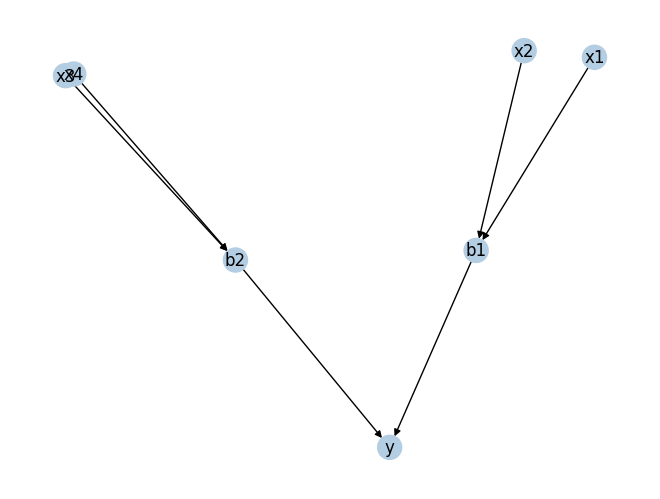

                                 Node Information                                  
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler ┃ Validator                   ┃ Value             ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x1   │ -            │ -       │ array_float_validator(-, 4) │ [0.1 0.1 0.1 0.1] │
│ x2   │ -            │ -       │ array_float_validator(-, 4) │ [0.2 0.2 0.2 0.2] │
│ x3   │ -            │ -       │ array_float_validator(-, 4) │ [0.3 0.3 0.3 0.3] │
│ x4   │ -            │ -       │ array_float_validator(-, 4) │ [0.4 0.4 0.4 0.4] │
│ b1   │ compare_func │ -       │ bool_validator              │ False             │
│ b2   │ compare_func │ -       │ bool_validator              │ False             │
│ y    │ compare_func │ -       │ bool_validator              │ True              │
└──────┴──────────────┴─────────┴─────────────────────────────┴───────────────────┘

In [13]:
dag.run(
    dict(
        x1=np.array([0.1] * SIZE_PER_INPUT),
        x2=np.array([0.2] * SIZE_PER_INPUT),
        x3=np.array([0.3] * SIZE_PER_INPUT),
        x4=np.array([0.4] * SIZE_PER_INPUT),
    )
)
dag.visualize()

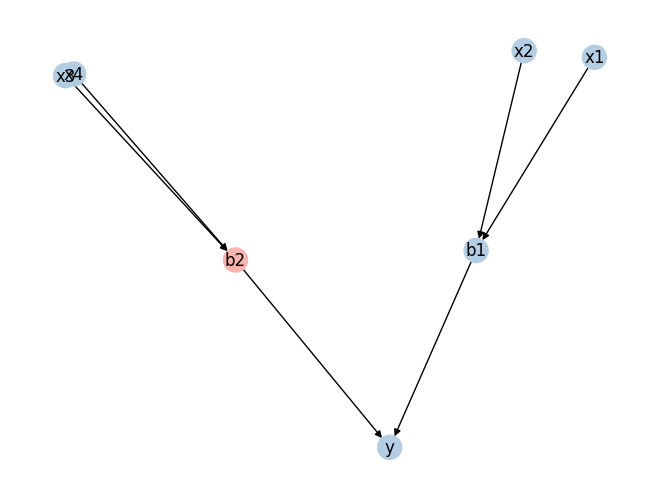

                                 Node Information                                  
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler ┃ Validator                   ┃ Value             ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x1   │ -            │ -       │ array_float_validator(-, 4) │ [0.1 0.1 0.1 0.1] │
│ x2   │ -            │ -       │ array_float_validator(-, 4) │ [0.2 0.2 0.2 0.2] │
│ x3   │ -            │ -       │ array_float_validator(-, 4) │ [0.3 0.3 0.3 0.3] │
│ x4   │ -            │ -       │ array_float_validator(-, 4) │ [0.4 0.4 0.4 0.4] │
│ b1   │ compare_func │ -       │ bool_validator              │ False             │
│ b2   │ compare_func │ -       │ bool_validator              │ True              │
│ y    │ compare_func │ -       │ bool_validator              │ False             │
└──────┴──────────────┴─────────┴─────────────────────────────┴───────────────────┘

In [14]:
dag.intervene_and_run(
    "b2",
    True,
    dict(
        x1=np.array([0.1] * SIZE_PER_INPUT),
        x2=np.array([0.2] * SIZE_PER_INPUT),
        x3=np.array([0.3] * SIZE_PER_INPUT),
        x4=np.array([0.4] * SIZE_PER_INPUT),
    ),
)
dag.visualize()

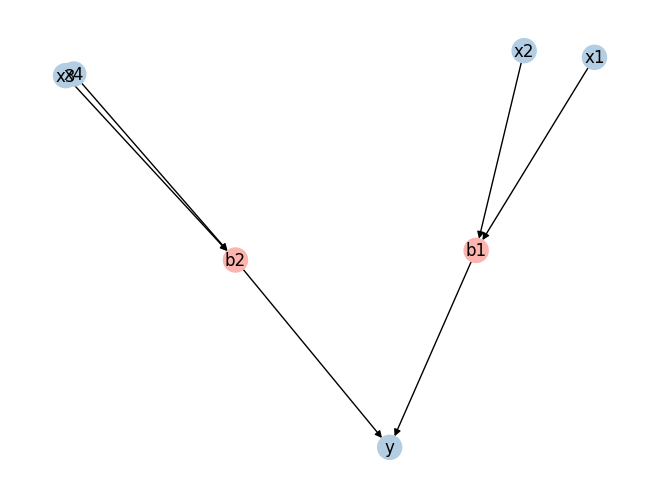

                           Node Information                            
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler ┃ Validator                   ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ -       │ array_float_validator(-, 4) │ -     │
│ x2   │ -            │ -       │ array_float_validator(-, 4) │ -     │
│ x3   │ -            │ -       │ array_float_validator(-, 4) │ -     │
│ x4   │ -            │ -       │ array_float_validator(-, 4) │ -     │
│ b1   │ compare_func │ -       │ bool_validator              │ False │
│ b2   │ compare_func │ -       │ bool_validator              │ False │
│ y    │ compare_func │ -       │ bool_validator              │ -     │
└──────┴──────────────┴─────────┴─────────────────────────────┴───────┘

In [15]:
dag.do_interchange_intervention(
    [["b1"], ["b2"]],
    [
    dict(
        x1=np.random.uniform(-0.5, 0.5, SIZE_PER_INPUT),
        x2=np.random.uniform(-0.5, 0.5, SIZE_PER_INPUT),
        x3=np.random.uniform(-0.5, 0.5, SIZE_PER_INPUT),
        x4=np.random.uniform(-0.5, 0.5, SIZE_PER_INPUT),
    ), 
    dict(
        x1=np.random.uniform(-0.5, 0.5, SIZE_PER_INPUT),
        x2=np.random.uniform(-0.5, 0.5, SIZE_PER_INPUT),
        x3=np.random.uniform(-0.5, 0.5, SIZE_PER_INPUT),
        x4=np.random.uniform(-0.5, 0.5, SIZE_PER_INPUT),
    )],
)
dag.visualize()

## Variable alignment

In [16]:
model

MLP(
  (hook_pre1): HookPoint()
  (layer1): Linear(in_features=16, out_features=16, bias=True)
  (hook_mid1): HookPoint()
  (hook_pre2): HookPoint()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (hook_mid2): HookPoint()
  (hook_pre3): HookPoint()
  (layer3): Linear(in_features=16, out_features=2, bias=True)
  (hook_mid3): HookPoint()
  (relu): ReLU()
)

In [17]:
def input_alignment(x: torch.tensor):
    x = to_numpy(x)
    if x.ndim == 1:
        return dict(
            x1=x[: SIZE_PER_INPUT],
            x2=x[SIZE_PER_INPUT : 2 * SIZE_PER_INPUT],
            x3=x[2 * SIZE_PER_INPUT : 3 * SIZE_PER_INPUT],
            x4=x[3 * SIZE_PER_INPUT :],
        )
    elif x.ndim == 2:
        return [
            dict(
                x1=x[i, : SIZE_PER_INPUT],
                x2=x[i, SIZE_PER_INPUT : 2 * SIZE_PER_INPUT],
                x3=x[i, 2 * SIZE_PER_INPUT : 3 * SIZE_PER_INPUT],
                x4=x[i, 3 * SIZE_PER_INPUT :],
            )
            for i in range(x.shape[0])
        ]
    else:
        raise ValueError("Invalid input shape")


def output_alignment(y: torch.tensor):
    return dict(y=torch.argmax(y).item())


variable_alignment = VariableAlignment(
    dag=dag,
    low_level_model=model,
    dag_nodes=["b1", "b2"],
    input_alignment=input_alignment,
    output_alignment=output_alignment,
    intervene_model_hooks=["hook_mid1"],
    subspaces_sizes=[8, 8],
    verbosity=1,
)

Running model to determine activation space size...


In [18]:
base_input = torch.rand(1, 4 * SIZE_PER_INPUT) - 0.5
source_inputs = torch.rand(len(variable_alignment.dag_nodes), 4 * SIZE_PER_INPUT) - 0.5
variable_alignment.get_distributed_interchange_intervention_hooks(base_input, source_inputs)

[('hook_mid1',
  functools.partial(<function VariableAlignment.get_distributed_interchange_intervention_hooks.<locals>.intervention_hook at 0x7f0580a3bec0>, space_index=0, new_activation_values=tensor([[-0.2880,  2.1428, -0.1159, -0.2093, -1.3856,  1.8681, -0.2614,  2.0296,
            1.4197, -1.1907,  0.1955, -0.5299,  1.4488, -1.2965, -0.5988, -1.1208]],
         device='cuda:0', grad_fn=<MmBackward0>)))]

In [19]:
variable_alignment.run_distributed_interchange_intervention(base_input, source_inputs)

tensor([[-59.7903,  60.4988]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [20]:
variable_alignment.run_interchange_intervention(base_input.squeeze(0), source_inputs)

tensor([1])

In [21]:
source_inputs.shape

torch.Size([2, 16])

In [22]:
variable_alignment.dii_training_objective_and_agreement(base_input, source_inputs)

(tensor(0., device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor([True], device='cuda:0'))

## Intervention intervention training

In [23]:
inputs, _ = generate_grouped_data(10000, SIZE_PER_INPUT)
inputs = torch.tensor(inputs, dtype=torch.float32)

In [24]:
variable_alignment.dag_nodes

['b1', 'b2']

In [25]:
ii_dataset = variable_alignment.create_interchange_intervention_dataset(inputs, num_samples=1000000)

In [26]:
print("Balance:", ii_dataset[:][2].sum().item() / ii_dataset[:][2].shape[0])

Balance: 0.50014


In [27]:
losses, accuracies = variable_alignment.train_rotation_matrix(ii_dataset=ii_dataset, num_epochs=100, batch_size=16000)

Epoch [1/100]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch [1/100]: 100%|██████████| 63/63 [00:08<00:00,  7.02it/s]


Loss: 18.35226, Accuracy: 0.62296


Epoch [2/100]: 100%|██████████| 63/63 [00:09<00:00,  6.94it/s]


Loss: 13.99179, Accuracy: 0.64080


Epoch [3/100]: 100%|██████████| 63/63 [00:08<00:00,  7.09it/s]


Loss: 12.95032, Accuracy: 0.64563


Epoch [4/100]: 100%|██████████| 63/63 [00:08<00:00,  7.19it/s]


Loss: 12.32489, Accuracy: 0.64968


Epoch [5/100]: 100%|██████████| 63/63 [00:08<00:00,  7.06it/s]


Loss: 11.59707, Accuracy: 0.65175


Epoch [6/100]: 100%|██████████| 63/63 [00:08<00:00,  7.19it/s]


Loss: 10.49690, Accuracy: 0.65796


Epoch [7/100]: 100%|██████████| 63/63 [00:08<00:00,  7.05it/s]


Loss: 9.71538, Accuracy: 0.66767


Epoch [8/100]: 100%|██████████| 63/63 [00:08<00:00,  7.01it/s]


Loss: 9.20542, Accuracy: 0.67698


Epoch [9/100]: 100%|██████████| 63/63 [00:09<00:00,  6.97it/s]


Loss: 8.64941, Accuracy: 0.68697


Epoch [10/100]: 100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Loss: 8.00986, Accuracy: 0.69936


Epoch [11/100]: 100%|██████████| 63/63 [00:08<00:00,  7.02it/s]


Loss: 7.36734, Accuracy: 0.71389


Epoch [12/100]: 100%|██████████| 63/63 [00:08<00:00,  7.01it/s]


Loss: 6.77280, Accuracy: 0.72848


Epoch [13/100]: 100%|██████████| 63/63 [00:08<00:00,  7.04it/s]


Loss: 6.12123, Accuracy: 0.74218


Epoch [14/100]: 100%|██████████| 63/63 [00:09<00:00,  6.94it/s]


Loss: 5.23795, Accuracy: 0.75605


Epoch [15/100]: 100%|██████████| 63/63 [00:08<00:00,  7.26it/s]


Loss: 3.96998, Accuracy: 0.77381


Epoch [16/100]: 100%|██████████| 63/63 [00:09<00:00,  6.99it/s]


Loss: 2.54034, Accuracy: 0.80173


Epoch [17/100]: 100%|██████████| 63/63 [00:09<00:00,  6.94it/s]


Loss: 1.35333, Accuracy: 0.83490


Epoch [18/100]: 100%|██████████| 63/63 [00:08<00:00,  7.04it/s]


Loss: 0.63973, Accuracy: 0.87308


Epoch [19/100]: 100%|██████████| 63/63 [00:08<00:00,  7.14it/s]


Loss: 0.36492, Accuracy: 0.90740


Epoch [20/100]: 100%|██████████| 63/63 [00:09<00:00,  6.98it/s]


Loss: 0.24644, Accuracy: 0.93297


Epoch [21/100]: 100%|██████████| 63/63 [00:08<00:00,  7.07it/s]


Loss: 0.17186, Accuracy: 0.95184


Epoch [22/100]: 100%|██████████| 63/63 [00:08<00:00,  7.09it/s]


Loss: 0.11854, Accuracy: 0.96568


Epoch [23/100]: 100%|██████████| 63/63 [00:08<00:00,  7.28it/s]


Loss: 0.08020, Accuracy: 0.97575


Epoch [24/100]: 100%|██████████| 63/63 [00:08<00:00,  7.18it/s]


Loss: 0.05393, Accuracy: 0.98292


Epoch [25/100]: 100%|██████████| 63/63 [00:08<00:00,  7.03it/s]


Loss: 0.03684, Accuracy: 0.98773


Epoch [26/100]: 100%|██████████| 63/63 [00:09<00:00,  6.98it/s]


Loss: 0.02623, Accuracy: 0.99094


Epoch [27/100]: 100%|██████████| 63/63 [00:08<00:00,  7.19it/s]


Loss: 0.01955, Accuracy: 0.99307


Epoch [28/100]: 100%|██████████| 63/63 [00:09<00:00,  6.99it/s]


Loss: 0.01521, Accuracy: 0.99452


Epoch [29/100]: 100%|██████████| 63/63 [00:09<00:00,  6.98it/s]


Loss: 0.01230, Accuracy: 0.99565


Epoch [30/100]: 100%|██████████| 63/63 [00:09<00:00,  6.69it/s]


Loss: 0.01025, Accuracy: 0.99643


Epoch [31/100]: 100%|██████████| 63/63 [00:09<00:00,  6.74it/s]


Loss: 0.00876, Accuracy: 0.99698


Epoch [32/100]: 100%|██████████| 63/63 [00:09<00:00,  6.59it/s]


Loss: 0.00764, Accuracy: 0.99741


Epoch [33/100]: 100%|██████████| 63/63 [00:09<00:00,  6.73it/s]


Loss: 0.00678, Accuracy: 0.99774


Epoch [34/100]: 100%|██████████| 63/63 [00:09<00:00,  6.55it/s]


Loss: 0.00609, Accuracy: 0.99801


Epoch [35/100]: 100%|██████████| 63/63 [00:09<00:00,  6.76it/s]


Loss: 0.00554, Accuracy: 0.99820


Epoch [36/100]: 100%|██████████| 63/63 [00:09<00:00,  6.79it/s]


Loss: 0.00509, Accuracy: 0.99837


Epoch [37/100]: 100%|██████████| 63/63 [00:09<00:00,  6.76it/s]


Loss: 0.00471, Accuracy: 0.99849


Epoch [38/100]: 100%|██████████| 63/63 [00:09<00:00,  6.57it/s]


Loss: 0.00439, Accuracy: 0.99861


Epoch [39/100]: 100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Loss: 0.00412, Accuracy: 0.99871


Epoch [40/100]: 100%|██████████| 63/63 [00:09<00:00,  6.74it/s]


Loss: 0.00388, Accuracy: 0.99881


Epoch [41/100]: 100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


Loss: 0.00368, Accuracy: 0.99889


Epoch [42/100]: 100%|██████████| 63/63 [00:09<00:00,  6.78it/s]


Loss: 0.00350, Accuracy: 0.99895


Epoch [43/100]: 100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Loss: 0.00335, Accuracy: 0.99901


Epoch [44/100]: 100%|██████████| 63/63 [00:09<00:00,  6.65it/s]


Loss: 0.00321, Accuracy: 0.99906


Epoch [45/100]: 100%|██████████| 63/63 [00:09<00:00,  6.76it/s]


Loss: 0.00308, Accuracy: 0.99911


Epoch [46/100]: 100%|██████████| 63/63 [00:09<00:00,  6.53it/s]


Loss: 0.00297, Accuracy: 0.99915


Epoch [47/100]: 100%|██████████| 63/63 [00:09<00:00,  6.87it/s]


Loss: 0.00287, Accuracy: 0.99919


Epoch [48/100]: 100%|██████████| 63/63 [00:09<00:00,  6.90it/s]


Loss: 0.00278, Accuracy: 0.99923


Epoch [49/100]: 100%|██████████| 63/63 [00:08<00:00,  7.30it/s]


Loss: 0.00269, Accuracy: 0.99926


Epoch [50/100]: 100%|██████████| 63/63 [00:08<00:00,  7.21it/s]


Loss: 0.00262, Accuracy: 0.99929


Epoch [51/100]: 100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


Loss: 0.00255, Accuracy: 0.99932


Epoch [52/100]: 100%|██████████| 63/63 [00:08<00:00,  7.10it/s]


Loss: 0.00249, Accuracy: 0.99934


Epoch [53/100]: 100%|██████████| 63/63 [00:08<00:00,  7.22it/s]


Loss: 0.00243, Accuracy: 0.99938


Epoch [54/100]: 100%|██████████| 63/63 [00:08<00:00,  7.19it/s]


Loss: 0.00237, Accuracy: 0.99940


Epoch [55/100]: 100%|██████████| 63/63 [00:08<00:00,  7.37it/s]


Loss: 0.00232, Accuracy: 0.99942


Epoch [56/100]: 100%|██████████| 63/63 [00:08<00:00,  7.09it/s]


Loss: 0.00228, Accuracy: 0.99944


Epoch [57/100]: 100%|██████████| 63/63 [00:08<00:00,  7.03it/s]


Loss: 0.00223, Accuracy: 0.99946


Epoch [58/100]: 100%|██████████| 63/63 [00:08<00:00,  7.14it/s]


Loss: 0.00219, Accuracy: 0.99947


Epoch [59/100]: 100%|██████████| 63/63 [00:08<00:00,  7.43it/s]


Loss: 0.00216, Accuracy: 0.99949


Epoch [60/100]: 100%|██████████| 63/63 [00:08<00:00,  7.42it/s]


Loss: 0.00212, Accuracy: 0.99950


Epoch [61/100]: 100%|██████████| 63/63 [00:08<00:00,  7.28it/s]


Loss: 0.00209, Accuracy: 0.99951


Epoch [62/100]: 100%|██████████| 63/63 [00:08<00:00,  7.11it/s]


Loss: 0.00206, Accuracy: 0.99952


Epoch [63/100]: 100%|██████████| 63/63 [00:08<00:00,  7.14it/s]


Loss: 0.00203, Accuracy: 0.99953


Epoch [64/100]: 100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


Loss: 0.00200, Accuracy: 0.99954


Epoch [65/100]: 100%|██████████| 63/63 [00:09<00:00,  6.97it/s]


Loss: 0.00197, Accuracy: 0.99955


Epoch [66/100]: 100%|██████████| 63/63 [00:08<00:00,  7.13it/s]


Loss: 0.00195, Accuracy: 0.99956


Epoch [67/100]: 100%|██████████| 63/63 [00:08<00:00,  7.38it/s]


Loss: 0.00192, Accuracy: 0.99957


Epoch [68/100]: 100%|██████████| 63/63 [00:08<00:00,  7.25it/s]


Loss: 0.00190, Accuracy: 0.99958


Epoch [69/100]: 100%|██████████| 63/63 [00:08<00:00,  7.32it/s]


Loss: 0.00188, Accuracy: 0.99958


Epoch [70/100]: 100%|██████████| 63/63 [00:08<00:00,  7.24it/s]


Loss: 0.00186, Accuracy: 0.99959


Epoch [71/100]: 100%|██████████| 63/63 [00:08<00:00,  7.28it/s]


Loss: 0.00184, Accuracy: 0.99960


Epoch [72/100]: 100%|██████████| 63/63 [00:08<00:00,  7.16it/s]


Loss: 0.00182, Accuracy: 0.99961


Epoch [73/100]: 100%|██████████| 63/63 [00:08<00:00,  7.21it/s]


Loss: 0.00181, Accuracy: 0.99961


Epoch [74/100]: 100%|██████████| 63/63 [00:08<00:00,  7.25it/s]


Loss: 0.00179, Accuracy: 0.99962


Epoch [75/100]: 100%|██████████| 63/63 [00:08<00:00,  7.25it/s]


Loss: 0.00177, Accuracy: 0.99962


Epoch [76/100]: 100%|██████████| 63/63 [00:08<00:00,  7.02it/s]


Loss: 0.00176, Accuracy: 0.99962


Epoch [77/100]: 100%|██████████| 63/63 [00:08<00:00,  7.05it/s]


Loss: 0.00174, Accuracy: 0.99963


Epoch [78/100]: 100%|██████████| 63/63 [00:09<00:00,  6.99it/s]


Loss: 0.00173, Accuracy: 0.99963


Epoch [79/100]: 100%|██████████| 63/63 [00:08<00:00,  7.12it/s]


Loss: 0.00172, Accuracy: 0.99964


Epoch [80/100]: 100%|██████████| 63/63 [00:08<00:00,  7.03it/s]


Loss: 0.00170, Accuracy: 0.99964


Epoch [81/100]: 100%|██████████| 63/63 [00:08<00:00,  7.10it/s]


Loss: 0.00169, Accuracy: 0.99965


Epoch [82/100]: 100%|██████████| 63/63 [00:09<00:00,  6.97it/s]


Loss: 0.00168, Accuracy: 0.99966


Epoch [83/100]: 100%|██████████| 63/63 [00:08<00:00,  7.07it/s]


Loss: 0.00167, Accuracy: 0.99966


Epoch [84/100]: 100%|██████████| 63/63 [00:09<00:00,  6.69it/s]


Loss: 0.00165, Accuracy: 0.99966


Epoch [85/100]: 100%|██████████| 63/63 [00:09<00:00,  6.94it/s]


Loss: 0.00164, Accuracy: 0.99966


Epoch [86/100]: 100%|██████████| 63/63 [00:09<00:00,  6.77it/s]


Loss: 0.00163, Accuracy: 0.99966


Epoch [87/100]: 100%|██████████| 63/63 [00:08<00:00,  7.17it/s]


Loss: 0.00162, Accuracy: 0.99966


Epoch [88/100]: 100%|██████████| 63/63 [00:08<00:00,  7.21it/s]


Loss: 0.00161, Accuracy: 0.99967


Epoch [89/100]: 100%|██████████| 63/63 [00:08<00:00,  7.12it/s]


Loss: 0.00160, Accuracy: 0.99967


Epoch [90/100]: 100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Loss: 0.00159, Accuracy: 0.99967


Epoch [91/100]: 100%|██████████| 63/63 [00:08<00:00,  7.27it/s]


Loss: 0.00158, Accuracy: 0.99967


Epoch [92/100]: 100%|██████████| 63/63 [00:08<00:00,  7.15it/s]


Loss: 0.00158, Accuracy: 0.99967


Epoch [93/100]: 100%|██████████| 63/63 [00:08<00:00,  7.10it/s]


Loss: 0.00157, Accuracy: 0.99968


Epoch [94/100]: 100%|██████████| 63/63 [00:09<00:00,  6.94it/s]


Loss: 0.00156, Accuracy: 0.99968


Epoch [95/100]: 100%|██████████| 63/63 [00:08<00:00,  7.01it/s]


Loss: 0.00155, Accuracy: 0.99968


Epoch [96/100]: 100%|██████████| 63/63 [00:09<00:00,  6.73it/s]


Loss: 0.00154, Accuracy: 0.99968


Epoch [97/100]: 100%|██████████| 63/63 [00:09<00:00,  6.69it/s]


Loss: 0.00153, Accuracy: 0.99968


Epoch [98/100]: 100%|██████████| 63/63 [00:08<00:00,  7.03it/s]


Loss: 0.00153, Accuracy: 0.99968


Epoch [99/100]: 100%|██████████| 63/63 [00:08<00:00,  7.10it/s]


Loss: 0.00152, Accuracy: 0.99968


Epoch [100/100]: 100%|██████████| 63/63 [00:08<00:00,  7.04it/s]

Loss: 0.00151, Accuracy: 0.99969


In [29]:
test_inputs, _ = generate_grouped_data(1000, SIZE_PER_INPUT)
test_inputs = torch.tensor(test_inputs, dtype=torch.float32)
loss, accuracy = variable_alignment.test_rotation_matrix(inputs=test_inputs, batch_size=16000)
print(f"Test loss: {loss:0.5f}, Test accuracy: {accuracy:0.5f}")

Creating interchange intervention dataset...


Testing: 100%|██████████| 1/1 [00:00<00:00, 55.06it/s]

Test loss: 0.00935, Test accuracy: 0.99800


In [30]:
px.line(y=losses, title="Loss", labels={"x": "Epoch", "y": "Loss"})

In [31]:
px.line(y=accuracies, title="Accuracies", labels={"x": "Epoch", "y": "Accuracy"})